In [1]:
# 10-11-2023, Oren - Classification Project Notebook

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from pandas import read_csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore")
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from xgboost import XGBClassifier

def csv_drive_path_generatoer(url):
 '''
 Help in read csv file directly from google drive.
 Make sure the csv format is standard.
 url:str - path to csv file example:
   url = 'https://drive.google.com/file/d/126JPZ3lYwdLyJ2d_7jxM9jMtZaOlF-Ld/view?usp=sharing'
 return : str
 '''
 path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
 return path

In [3]:
link_X_train = 'https://drive.google.com/file/d/11Dgctv-N6z3ugQOpRrFNKVP5NNqPPWxK/view?usp=drive_link'
link_y_train = 'https://drive.google.com/file/d/1NDF2aCymR4zjYK9mLYNRwIdB_EyE5ZHl/view?usp=drive_link'

link_X_test = 'https://drive.google.com/file/d/1ZRg80tYdBO1pcd_6R1m_tiijZSfDXMZ6/view?usp=drive_link'

path_X_train = csv_drive_path_generatoer(link_X_train)
path_y_train = csv_drive_path_generatoer(link_y_train)

path_X_test = csv_drive_path_generatoer(link_X_test)

X_train = read_csv(path_X_train, index_col = 0)
y_train = read_csv(path_y_train, index_col = 0)

X_test = read_csv(path_X_test, index_col = 0)

train_data = X_train.join(y_train).set_index('id')

In [4]:
# import seaborn as sns
# sns.pairplot(scaled_train_data, hue = 'LeaveOrNot')

In [5]:
# Defining a data-Transformation class to elegantly perform all data transformation steps by class methods upon class object instansiation 
# can be accessed via the .data class attribute

# 0. Remove nulls
# 1. add tenure feature - current - specified year
# 2. Transform Education values to 1, 2, 3
# 3. Transform EverBenched values to 1 or 0
# 4. Gender, City & Race - One-Hot encoding
# 5. remove extra columns

class DataTransformer:
    
    def __init__(self, data):
        self.data = data
        self.remove_nulls()
        self.add_tenure()
        self.numeric_education()
        self.numeric_everbenched()
        self.one_hot_encoder()
        self.remove_extra_columns()
            
    def remove_nulls(self, column = 'Age'):
        self.data = self.data[~self.data[column].isnull()]
    
    def add_tenure(self,current_year = 2023):
        self.data["Loan's_Tenure"] = current_year - self.data.JoiningYear

    def numeric_education(self):
        self.data['Education'] = self.data['Education'].replace({'Bachelors': 1,'Masters': 2,'PHD': 3})
        
    def numeric_everbenched(self):
        self.data['EverBenched'] = self.data['EverBenched'].replace({'Yes':1, 'No': 0})        

    def one_hot_encoder(self, columns = ['Gender', 'Race', 'City']):
        self.data = pd.get_dummies(self.data, columns = columns, prefix = columns, dtype = int)
            
    def remove_extra_columns(self):
        self.data = self.data.drop(columns = ['JoiningYear'])

In [6]:
# Create an instance of the DataTransformer and save the transformed df via the .data class attribute configured

trans_train_data = DataTransformer(train_data)

trans_train_data = trans_train_data.data

trans_train_data


,Education,PaymentTier,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Loan's_Tenure,Gender_Female,Gender_Male,Race_black,Race_red,Race_white,Race_yellow,City_Bangalore,City_New Delhi,City_Pune
id,,,,,,,,,,,,,,,,
1847,1,3,27.0,1,4,0,7,0,1,0,0,1,0,1,0,0
2905,1,3,28.0,0,4,0,11,0,1,0,0,1,0,1,0,0
4610,1,3,26.0,0,2,1,8,1,0,0,0,1,0,0,0,1
2228,1,3,29.0,0,1,0,11,0,1,1,0,0,0,1,0,0
5,1,3,24.0,0,0,0,7,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,1,3,38.0,0,0,0,7,1,0,0,0,1,0,1,0,0
1099,2,2,29.0,0,5,1,6,0,1,0,0,1,0,0,0,1
2514,1,3,31.0,0,5,0,7,0,1,1,0,0,0,0,0,1


<Axes: >

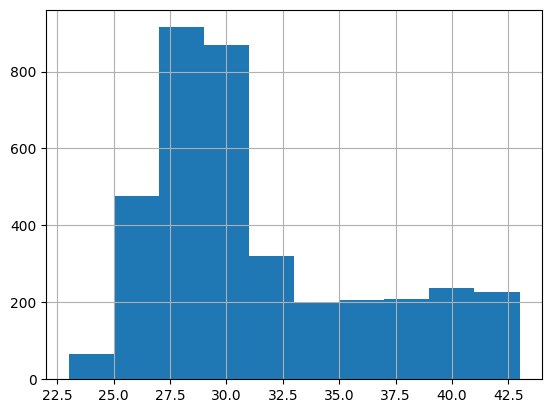

In [37]:
trans_train_data.Age.hist()

In [7]:
# Data Normalization/Scaling from 0 to 1 (per feature)
# scaler = MinMaxScaler()
scaler = RobustScaler()
scaled_train_data = pd.DataFrame(scaler.fit_transform(trans_train_data), index=trans_train_data.index, columns=trans_train_data.columns)
# scaled_train_data

In [8]:
# seperating the original train data to X and y:
X = scaled_train_data.drop(columns = 'LeaveOrNot')
y = scaled_train_data.LeaveOrNot

# Train_test_split - splitting original train data to train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
# Create single decision tree classifier 

clf_dt = DecisionTreeClassifier(max_depth = 8)
clf_dt.fit(X_train, y_train)

y_test_pred = clf_dt.predict(X_test)

In [30]:
clf_dt.feature_importances_

array([0.12128851, 0.21266361, 0.07331023, 0.01134081, 0.04425036,
       0.37886468, 0.01047201, 0.04730739, 0.00273275, 0.        ,
       0.        , 0.00272117, 0.01906594, 0.01285121, 0.06313134])

In [32]:
dtc_fi = pd.DataFrame({'features': X_train.columns, 'feature importances': clf_dt.feature_importances_})
feature_imp = dtc_fi.sort_values(by = 'feature importances', ascending = False)['features'].values.tolist()
# dtc_fi.sort_values(by = 'feature importances', ascending = False)
dtc_fi.sort_values(by = 'feature importances', ascending = False)

,features,feature importances
5,Loan's_Tenure,0.378865
1,PaymentTier,0.212664
0,Education,0.121289
2,Age,0.073310
14,City_Pune,0.063131
7,Gender_Male,0.047307
4,ExperienceInCurrentDomain,0.044250
12,City_Bangalore,0.019066
13,City_New Delhi,0.012851
3,EverBenched,0.011341


In [11]:
# evaluate the results

# Confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_test_pred)
target_names = ['0', '1']
cm = pd.DataFrame(data = cm, index = target_names, columns = target_names)
print(cm)

# Classification report
cr = classification_report(y_test,y_test_pred, target_names = target_names)
print(cr)
print(f1_score(y_test, y_test_pred))

     0    1
0  736   44
1  146  302
              precision    recall  f1-score   support

           0       0.83      0.94      0.89       780
           1       0.87      0.67      0.76       448

    accuracy                           0.85      1228
   macro avg       0.85      0.81      0.82      1228
weighted avg       0.85      0.85      0.84      1228

0.760705289672544


In [12]:
def plot_roc_curve(X_train, X_test, y_train, y_test, ensemble_classifier):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # clf = DecisionTreeClassifier()
    # model_a_bagging = BaggingClassifier(estimator = base_model, n_estimators= 100)

    # fitting the models
    ensemble_classifier.fit(X_train, y_train)

    # predict probabilities
    probas = ensemble_classifier.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    probas = probas[:,1]

    # calculate rocs auc scores
    auc = roc_auc_score(y_test, probas)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label = 1)
    fpr, tpr, _ = roc_curve(y_test, probas, pos_label = 1)

    # plot the roc curve for the model

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=f"{ensemble_classifier}, auc = {auc:.3f}")

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # show the legend
    plt.legend(fontsize = 8)


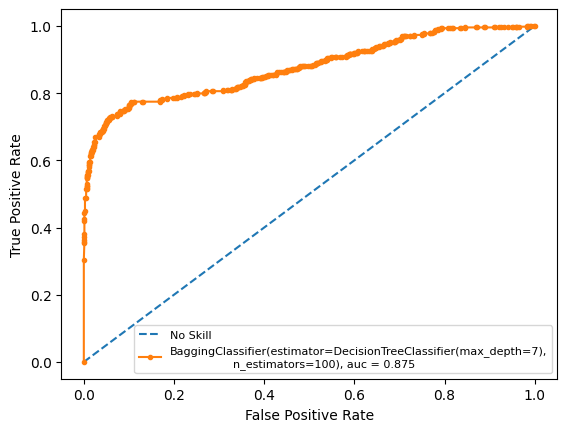

In [13]:
plot_roc_curve(X_train, X_test, y_train, y_test, BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 7), n_estimators = 100))

In [14]:
clf_adaboost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 7), n_estimators = 100,
                                  learning_rate=0.01)
clf_adaboost.fit(X_train, y_train)
print(f"DT ADA boosting classifier:\n \
    \ttrain accuracy: {clf_adaboost.score(X_train, y_train):.2f}\n \
    \ttest accuracy: {clf_adaboost.score(X_test, y_test):.2f}")

DT ADA boosting classifier:
     	train accuracy: 0.91
     	test accuracy: 0.83


In [15]:
# pip install xgboost

In [16]:
clf_xgb = XGBClassifier()

In [17]:
clf_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [18]:
# rfc = RandomForestClassifier()
# rfc_params = {'max_depth': [5,10,15,20,40,100], 'max_features': [2,3,4,5,6,7,8,9]}
# gs_rfc = GridSearchCV(rfc, rfc_params, cv = 5, scoring='accuracy')
# gs_rfc.fit(X_train, y_train)
# print(gs_rfc.best_params_)

In [19]:
# gs_rfc.best_score_

In [20]:
bagging_clf = BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 7))
bag_params = {'bootstrap': [True,False], 'bootstrap_features': [False,True],\
              'max_features': [6,7,8],
                'oob_score': [True,False],
                 'warm_start': [True]}


gs_bag = GridSearchCV(bagging_clf, bag_params, cv = 5, scoring = 'f1')
gs_bag.fit(X_train, y_train)
gs_bag.best_score_

# bagging_clf.get_params()
# bagging_params = {'max_depth': [5,10,15,20,40,100], 'max_features': [2,3,4,5,6,7,8,9]}
# gs_rfc = GridSearchCV(rfc, rfc_params, cv = 5, scoring='f1')
# gs_rfc.fit(X_train, y_train)
# print(gs_rfc.best_params_)

0.6758116191431338

In [21]:
# gs_bag.best_params_

In [22]:
# BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 7), n_estimators = 100).get_params()

In [23]:
# from sklearn.model_selection import RandomizedSearchCV
# import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.00001, 0.01),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.009766832415146781, 'max_depth': 7, 'n_estimators': 162, 'subsample': 0.8254441370290336}
Best score:  0.8262420423175669


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from pandas import read_csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

f1s, precisions, recalls, accuracies, classifiers_as_str = [],[],[],[], []
features, i_s = [], []
# classifiers = [XGBClassifier(learning_rate = 0.009956053586134729, max_depth = 6, n_estimators = 76, subsample = 0.6838981373746974), AdaBoostClassifier,\
#             KNeighborsClassifier(), LogisticRegression(), DecisionTreeClassifier(), GradientBoostingClassifier(), RandomForestClassifier()]

classifiers = [DecisionTreeClassifier(),KNeighborsClassifier(), LogisticRegression(),GradientBoostingClassifier(), RandomForestClassifier(),\
               AdaBoostClassifier(),XGBClassifier(learning_rate = 0.01, max_depth = 7, n_estimators = 100, subsample = 0.786)]
              
for classifier in classifiers:
    # for i in range(1,len(feature_imp)+1):
    #     X_train = X_train[feature_imp[:i]]
    #     X_train.columns = [feature_imp[:i]
    #     # X_test = X_test[feature_imp[:i]]
    #     print(X_train)
    #     # print(X_test)
        
    model = classifier
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test,y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1s.append(f1.round(3))
    precisions.append(precision.round(3))
    recalls.append(recall.round(3))
    accuracies.append(accuracy.round(3))
    # i_s.append(i)
    classifiers_as_str.append(str(classifier).split('(')[0])

report = pd.DataFrame({'classifier': classifiers_as_str,'accuracy': accuracies, 'recall':recalls,'precision':precisions,'f1_score': f1s})
print(report.sort_values(by = 'f1_score', ascending=False))

                   classifier  accuracy  recall  precision  f1_score
6               XGBClassifier     0.857   0.641      0.950     0.765
3  GradientBoostingClassifier     0.831   0.623      0.877     0.728
4      RandomForestClassifier     0.814   0.665      0.793     0.723
0      DecisionTreeClassifier     0.796   0.696      0.732     0.714
5          AdaBoostClassifier     0.788   0.531      0.826     0.647
1        KNeighborsClassifier     0.755   0.549      0.713     0.620
2          LogisticRegression     0.719   0.415      0.691     0.519


In [35]:
# Inspect the XGBClassifer confusion matrix:
model = XGBClassifier()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
xgb_cm = pd.DataFrame(data = confusion_matrix(y_test, y_test_pred), index = target_names, columns = target_names)
print(xgb_cm)

     0    1
0  723   57
1  136  312


In [ ]:
# To do 17-11-2023 (Raz S):
# 1. cm of the different models
# 2. Actual vs. predicted probas
# 3. Look at features of false positive vs. true positive
# 4. Balance_classes (bool)
# 5. Class weights (Loss handling)